# Introduction
 we'll build a custom chat executor that allows a Language Learning Model (LLM) to dynamically decide whether to return the result of a tool call as the final answer or to process it further before responding. This approach is particularly useful when you have tools that can generate acceptable final answers on their own, and you want the LLM to intelligently determine when this is the case.

The example builds upon the base chat executor, so it's recommended to familiarize yourself with that before proceeding. We'll be creating the agent from scratch for transparency, though similar functionality can be achieved using the create_react_agent constructor provided by LangChain.

By following this guide, you'll learn how to:

1.  Set up the necessary tools and APIs.
2. Define a custom tool with additional parameters.
3. Implement an agent state and a state graph to manage the conversation flow.
4. Build a chat agent that can decide when to finalize a response based on the  output of tool invocations.

This hands-on example will give you a deeper understanding of how to build flexible and context-aware chat agents using LangChain and LangGraph.

# 1. Setup and Installation

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain_openai tavily-python

# Code Explanation
* Purpose: This block installs the necessary Python packages:
  * langgraph: For creating and managing graphs in LangChain.
  * langchain: For working with LLMs and their tools.
  * langchain_openai: Specifically for integrating OpenAI models.
tavily-python: For using the Tavily search tool.

In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = ""


* Purpose: This block sets up the environment variables for the OpenAI and Tavily API keys. These keys are essential for authenticating your requests to these services.

# 2. Setting Up the Tools
We will first define the tools we want to use. For this simple example, we will use a built-in search tool via Tavily. However, it is really easy to create your own tools - see documentation here on how to do that.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field  # Import BaseModel and Field from Pydantic, used for data validation and model creation

# Define a class called SearchTool that inherits from BaseModel
class SearchTool(BaseModel):
    """A model representing an online search tool, with an option for direct result return."""

    # Define a field 'query' which is a string, representing the search query
    query: str = Field(description="The search query to look up online")

    # Define a field 'return_direct' which is a boolean, determining whether the result is returned directly
    return_direct: bool = Field(
        description="Indicates if the result should be returned directly to the user without processing or viewing by the agent",
        default=False,  # Set the default value to False, meaning the result is not returned directly unless specified
    )


# Code Explanation
The SearchTool class is a data model used to define the structure for an online search tool. It has two attributes:
* query: A string representing the search query.
* return_direct: A boolean indicating whether the search result should be returned directly to the user without any additional processing or oversight.


The BaseModel from Pydantic ensures that these fields are validated and serialized correctly, making it easier to work with structured data in Python.

In [ ]:
!pip install langchain langchain-community

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults  # Import TavilySearchResults from the langchain_community.tools.tavily_search module

# Create an instance of TavilySearchResults with specific configurations
search_tool = TavilySearchResults(
    max_results=1,  # Limit the search results to a maximum of 1 result
    args_schema=SearchTool  # Use the SearchTool class to define the schema for search arguments
)

# Create a list containing the search_tool instance
tools = [search_tool]  # This list can be used to manage and access different tools


 This code snippet sets up a search tool using the Tavily search engine or API, configures it to return a maximum of one result, and ensures that the search query adheres to the structure defined by the SearchTool class.

* TavilySearchResults: Represents the search tool.
* max_results=1: Limits the search to one result.
* args_schema=SearchTool: Ensures that the input follows the SearchTool schema.
* tools = [search_tool]: Prepares a list containing the search_tool, which can be passed into other parts of your code, such as an agent that uses this tool to perform searches.

# 3. Tool Executor
We can now wrap these tools in a simple ToolExecutor. This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output. A ToolInvocation is any class with tool and tool_input attribute.

In [ ]:
from langgraph.prebuilt import ToolExecutor  # Import ToolExecutor from langgraph.prebuilt to manage and execute tools

tool_executor = ToolExecutor(tools)  # Create an instance of ToolExecutor, providing the list of tools to be managed and executed


<ipython-input-13-a7d6763a57d7>:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)  # Create an instance of ToolExecutor, providing the list of tools to be managed and executed


* Purpose: This creates a ToolExecutor instance that can execute the tools defined earlier. The ToolExecutor is responsible for taking a ToolInvocation and returning the output.

# 4. Setting Up the Model
Now we need to load the chat model we want to use. Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

In [ ]:
from langchain_openai import ChatOpenAI  # Import ChatOpenAI to use OpenAI's chat model

# Create an instance of ChatOpenAI with specific settings
model = ChatOpenAI(
    temperature=0,  # Set temperature to 0 for more deterministic responses (less randomness)
    streaming=True  # Enable streaming to receive responses in real-time as they are generated
)

# Bind the previously defined tools to the model, so it can use them during its operation
model = model.bind_tools(tools)


# Explanation:

* ChatOpenAI: This loads the OpenAI chat model that will handle the conversation. The temperature=0 makes the model deterministic (it won't generate random responses).
* bind_tools: Associates the defined tools with the model so it knows these tools are available for use. binds the tools (like the Tavily search tool) to the model, allowing the model to use these tools during conversation.

# 5. Defining Agent State
In LangGraph, when we talk about the "agent state," we're referring to a piece of data that keeps track of what's happening as the agent moves through different parts of the graph.

# Breaking it Down:
**StateGraph:**

* This is the main structure in LangGraph that controls how the agent moves through various steps (or nodes) in the graph.

**State Object:**

* This is like a notebook that the StateGraph carries around. It holds information that might change as the agent goes from one node to another.

**Nodes and State Updates:**

* Each node in the graph does something specific. When the agent reaches a node, that node can either:

**SET:** Change something in the state notebook (like replacing an old note with a new one).
**ADD:** Add something new to the state notebook without changing what's already there.

**Example with Messages:**

* Imagine the state notebook is just a list where you jot down messages. As the agent moves through different nodes, each node adds a new message to this list.
* We use something called a TypedDict to define what this notebook looks like. In this case, it has one key, messages, which is just a list where new messages are added as the agent moves along.

So, the "agent state" is basically a way to track what's happening as the agent progresses through different tasks, with each step either adding to or changing the information being tracked.

In [ ]:
import operator  # Import the operator module for functions that can be used with operators

from typing import Annotated, Sequence, TypedDict  # Import types for type hinting and type definitions

from langchain_core.messages import BaseMessage  # Import BaseMessage to represent messages in the workflow

# Define a class called AgentState that specifies the structure of the state dictionary
class AgentState(TypedDict):
    # Define a field 'messages' which is a sequence (list) of BaseMessage objects
    messages: Annotated[Sequence[BaseMessage], operator.add]  # Annotate with operator.add for special handling or metadata


# Explanation:

AgentState: This defines the structure of the state that will be passed around between different nodes (components) in the workflow. It contains a list of messages that represent the conversation history.

# 6. Defining the Nodes
We now need to define a few different nodes in our graph. In langgraph, a node can be either a function or a runnable. There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges. Some of these edges may be conditional. The reason they are conditional is that based on the output of a node, one of several paths may be taken. The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either: a. If the agent said to take an action, then the function to invoke tools should be called b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**MODIFICATION**

We change the should_continue function to check whether return_direct was set to True

In [ ]:
from langchain_core.messages import ToolMessage  # Import ToolMessage for handling messages related to tools
from langgraph.prebuilt import ToolInvocation  # Import ToolInvocation to create and manage tool calls

# Define a function to decide whether to continue processing based on the state
def should_continue(state):
    messages = state["messages"]  # Get the list of messages from the state
    last_message = messages[-1]  # Get the most recent message

    # Check if the last message has any tool calls
    if not last_message.tool_calls:
        return "end"  # If no tool calls, return "end" to stop processing
    else:
        # Get the arguments of the first tool call in the last message
        arguments = last_message.tool_calls[0]["args"]

        # Check if the "return_direct" argument is set to True
        if arguments.get("return_direct", False):
            return "final"  # If "return_direct" is True, return "final" to process the result directly
        else:
            return "continue"  # If "return_direct" is not True, return "continue" to proceed with further processing


# Explanation:

should_continue: Decides whether to continue processing or to end the conversation. It checks if the tool's response should be returned directly (return_direct=True), and based on that, decides the next step.

In [ ]:
def call_model(state):  # Define a function named 'call_model' that takes one argument 'state'
    messages = state["messages"]  # Extract the value associated with the key 'messages' from the 'state' dictionary and store it in the variable 'messages'
    response = model.invoke(messages)  # Use the 'invoke' method of 'model' to process 'messages' and store the result in the variable 'response'
    return {"messages": [response]}  # Return a dictionary with the key 'messages' and the value as a list containing 'response'


* call_model: Calls the language model with the current conversation history and appends the model’s response to the message list.

**MODIFICATION**

We change the tool calling to get rid of the return_direct parameter (not used in the actual tool call)

In [ ]:
def call_tool(state):  # Define a function named 'call_tool' that takes one argument 'state'
    messages = state["messages"]  # Extract the 'messages' list from the 'state' dictionary
    last_message = messages[-1]  # Get the last message in the 'messages' list
    tool_call = last_message.tool_calls[0]  # Extract the first tool call from the 'tool_calls' list in the last message
    tool_name = tool_call["name"]  # Get the name of the tool from the 'tool_call' dictionary
    arguments = tool_call["args"]  # Get the arguments for the tool from the 'tool_call' dictionary

    if tool_name == "tavily_search_results_json":  # Check if the tool name is "tavily_search_results_json"
        if "return_direct" in arguments:  # Check if the argument "return_direct" exists in the 'arguments' dictionary
            del arguments["return_direct"]  # If it exists, delete the "return_direct" key from the 'arguments' dictionary

    action = ToolInvocation(tool=tool_name, tool_input=arguments)  # Create an action using 'ToolInvocation' with the tool's name and the modified arguments
    response = tool_executor.invoke(action)  # Invoke the tool action using 'tool_executor' and store the response

    tool_message = ToolMessage(content=str(response), name=action.tool, tool_call_id=tool_call["id"])  # Create a new 'ToolMessage' with the response content, tool name, and tool call ID
    return {"messages": [tool_message]}  # Return a dictionary containing the new 'tool_message' in a list under the key 'messages'


* call_tool: Executes the selected tool, removes the return_direct flag from the tool’s input (since the tool doesn’t need it), and then formats the tool’s response as a message to be added to the state.

# Step 8: Define the Workflow (Graph)

**Define the graph**

We can now put it all together and define the graph!

**MODIFICATION**

We add a separate node for any tool call where return_direct=True. The reason this is needed is that after this node we want to end, while after other tool calls we want to go back to the LLM.

In [ ]:
from langgraph.graph import END, StateGraph, START  # Import necessary components from langgraph: END, StateGraph, and START

workflow = StateGraph(AgentState)  # Create a new workflow (StateGraph) starting with the AgentState

workflow.add_node("agent", call_model)  # Add a node called "agent" that runs the call_model function
workflow.add_node("action", call_tool)  # Add a node called "action" that runs the call_tool function
workflow.add_node("final", call_tool)  # Add a node called "final" that also runs the call_tool function

workflow.add_edge(START, "agent")  # Connect the START point to the "agent" node, making "agent" the first step

workflow.add_conditional_edges(  # Add conditional paths from the "agent" node based on a condition
    "agent",  # The starting node for the condition
    should_continue,  # The function that decides the path based on the condition
    {"continue": "action", "final": "final", "end": END},  # The possible paths: to "action", "final", or END
)

workflow.add_edge("action", "agent")  # Connect the "action" node back to the "agent" node, creating a loop
workflow.add_edge("final", END)  # Connect the "final" node to END, meaning the workflow ends here

app = workflow.compile()  # Compile the workflow into an application that can be executed


# Explanation:

* StateGraph: Defines the flow of the conversation. Nodes represent different functions, and edges represent transitions between these nodes.
* add_node: Adds the nodes (steps) to the graph:
* agent: Calls the language model.
* action: Executes a tool.
* final: Executes a tool and then ends.
* add_edge: Specifies the order in which nodes are called. For example, after the agent node, it checks whether to continue to the action node, go to the final node, or end the conversation.
* compile: Finalizes the workflow into a runnable application.

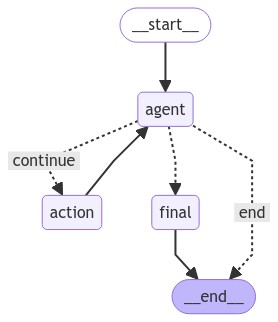

In [ ]:
from IPython.display import Image, display  # Import the Image and display functions from IPython.display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))  # Try to display a visual representation of the workflow as a PNG image
except Exception:  # If an error occurs (like missing dependencies), handle it here
    # This requires some extra dependencies and is optional
    pass  # Ignore the error and do nothing, allowing the program to continue running


# Step 9: Run the Application

In [ ]:
from langchain_core.messages import HumanMessage  # Import the HumanMessage class to create human-like messages

# Create an input dictionary with a message asking about the weather in Pakistan
inputs = {"messages": [HumanMessage(content="what is the weather in Pakistan")]}

# Run the workflow using the input and stream the outputs
for output in app.stream(inputs):

    # Loop through each item (node's output) in the streamed output
    for key, value in output.items():
        print(f"Output from node '{key}':")  # Print the name of the node that produced the output
        print("---")  # Print a separator line for clarity
        print(value)  # Print the actual output from the node

    print("\n---\n")  # Add a blank line with separators between different outputs


Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ab0ixNiPuhf6JoY9hgNqOVAw', 'function': {'arguments': '{"query":"weather in Pakistan"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-4e079be0-6f29-42d1-b7f5-dd20ed9bab69-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Pakistan'}, 'id': 'call_ab0ixNiPuhf6JoY9hgNqOVAw', 'type': 'tool_call'}])]}

---



<ipython-input-18-41c3f260fbee>:12: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(tool=tool_name, tool_input=arguments)  # Create an action using 'ToolInvocation' with the tool's name and the modified arguments


Output from node 'action':
---
{'messages': [ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Islamabad\', \'region\': \'Islamabad\', \'country\': \'Pakistan\', \'lat\': 33.7, \'lon\': 73.17, \'tz_id\': \'Asia/Karachi\', \'localtime_epoch\': 1724923999, \'localtime\': \'2024-08-29 14:33\'}, \'current\': {\'last_updated_epoch\': 1724923800, \'last_updated\': \'2024-08-29 14:30\', \'temp_c\': 25.1, \'temp_f\': 77.2, \'is_day\': 1, \'condition\': {\'text\': \'Patchy rain nearby\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/176.png\', \'code\': 1063}, \'wind_mph\': 6.5, \'wind_kph\': 10.4, \'wind_degree\': 358, \'wind_dir\': \'N\', \'pressure_mb\': 1006.0, \'pressure_in\': 29.7, \'precip_mm\': 0.08, \'precip_in\': 0.0, \'humidity\': 80, \'cloud\': 89, \'feelslike_c\': 27.2, \'feelslike_f\': 81.0, \'windchill_c\': 25.1, \'windchill_f\': 77.2, \'heatindex_c\': 27.2, \'heatindex_f\': 81.0, \'dewpoint_c\': 21.5, \'dewpoint_f\': 

# Explanation:

* HumanMessage: The user’s input message to the chat agent.
* app.stream(inputs): Runs the compiled graph with the provided input, simulating a conversation where the LLM and tools interact based on the workflow.
* for output in app.stream(inputs): Loops through the outputs of each node, printing the result.

# Summary of the Project
This project involves modifying a base chat agent executor, which is a system designed to interact with a language model (LLM) and tools in a loop. The modification allows the agent to dynamically decide whether to return the result of a tool call directly to the user without further processing, based on the specific context.

# Purpose of the Project
The purpose of this project is to create a more flexible and efficient chat agent that can:

Directly return tool results to the user when the result is already sufficient as a final answer.
Decide dynamically, based on the context, whether to return the result directly or to involve the LLM for further processing or summarization.
This is particularly useful when some tools provide results that can sometimes be used as the final response. Instead of always processing the tool's output through the LLM, the agent can return the result directly if it's deemed appropriate, saving time and computational resources.

This approach ensures that the chat agent can handle cases where direct responses are sufficient while still allowing for more complex processing when needed.